# Introduction

Now, more than ever, algorithms are responsible for life-changing choices
such as recruitment or loan allocation. Therefore, the question of algorithmic
fairness is central if we wish to make our society fairer and more inclusive.


This project aims at measuring the fairness of a neural network used to
classify pictures of humans. More specifically, we’re interested in knowing if
there are biases with respect to protected categories such as gender or age and
finding ways to alleviate those biases.


We’re building an attractiveness classifier, i.e a classifier that should separate human images into two categories : attractive or unattractive. This classifier is going to be evaluated in terms of biases with respect to protected categories in order to measure its fairness.


**Importante note :** This notebook contains only the source code of the project. For explanations please look at the report.

# Imports

## Mounting the drive

In [ ]:
#mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#drive path
drive_path = "drive/My Drive/DTU/Deep Learning/"

## Importing the images

In [ ]:
#unzipping the images from the drive into the local environment
import zipfile
with zipfile.ZipFile(drive_path+"ProjetDL/images.zip","r") as zip_ref:
  zip_ref.extractall("lesimages/")

In [ ]:
#checking the loading
import os
root = 'lesimages/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


## Other imports needed

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from PIL import Image
import torch
import os
import random
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
import torch.optim as optim
from google.colab.patches import cv2_imshow
import cv2

# Creating the sets

## The DataLoader

**Note :** The code for this dataloader is heavily inspired by https://github.com/yunjey/stargan/blob/master/data_loader.py

In [ ]:
class CelebA(data.Dataset):
    """Dataset class for the CelebA dataset."""

    def __init__(self, image_dir, attr_path,  split_path, selected_attrs, transform, mode):
        """Initialize and preprocess the CelebA dataset."""
        self.image_dir = image_dir
        self.attr_path = attr_path
        self.split_path = split_path
        self.selected_attrs = selected_attrs
        self.transform = transform
        self.mode = mode
        self.train_dataset = []
        self.train_dataset_with_added_bald = []
        self.test_dataset = []
        self.valid_dataset = []
        self.all_dataset = []
        self.all_dataset_with_added_bald = []
        self.attr2idx = {}
        self.idx2attr = {}
        self.preprocess()

        if mode == 'train':
            self.num_images = len(self.train_dataset)
        elif mode == 'valid':
            self.num_images = len(self.valid_dataset)
        else:
            self.num_images = len(self.test_dataset)

    def preprocess(self):
        """Preprocess the CelebA attribute file."""
        dict_split = dict()
        lines = [line.rstrip() for line in open(self.split_path, 'r')]
        for line in lines:
          split = line.split()
          dict_split[split[0]]=int(split[1])

        lines = [line.rstrip() for line in open(self.attr_path, 'r')]
        all_attr_names = lines[1].split()
        for i, attr_name in enumerate(all_attr_names):
            self.attr2idx[attr_name] = i
            self.idx2attr[i] = attr_name

        lines = lines[2:]
        random.seed(1234)
        random.shuffle(lines)
        for i, line in enumerate(lines):
            split = line.split()
            filename = split[0]
            values = split[1:]

            label = []
            all_label = []

            for attr_name in self.attr2idx.keys():
                idx = self.attr2idx[attr_name]
                all_label.append(values[idx] == '1')
            for attr_name in self.selected_attrs:
                idx = self.attr2idx[attr_name]
                label.append(values[idx] == '1')

            if (self.mode == 'train'):
              if (dict_split[filename] == 0):

##### --- Uncomment the following lines in order to introduce data into de sets (repetition of images with a chosen attribute) --- #####
                # if all_label[4] == True:
                #   for i in range(1,10):
                #     im = Image.open("lesimages/img_align_celeba/"+filename) 
                #     im.save("lesimages/img_align_celeba/new_image_"+filename.split(".")[0]+str(i)+".png")
                #     self.train_dataset.append(["new_image_"+filename.split(".")[0]+str(i)+".png",label])
                #     self.all_dataset.append(["new_image_"+filename.split(".")[0]+str(i)+".png", all_label])

                self.train_dataset.append([filename, label])
                self.all_dataset.append([filename, all_label])
            elif (self.mode == 'valid'):
              if (dict_split[filename] == 1):
                self.valid_dataset.append((filename, label))
                self.all_dataset.append([filename, all_label])
            else:
              if (dict_split[filename] == 2):
                self.test_dataset.append((filename, label))
                self.all_dataset.append([filename, all_label])

        print('Finished preprocessing the CelebA dataset...')

    def __getitem__(self, index):
        """Return one image and its corresponding attribute label."""
        dataset = self.train_dataset if self.mode == 'train' else self.valid_dataset if self.mode == 'valid' else self.test_dataset
        filename, label = dataset[index]
        image = Image.open(os.path.join(self.image_dir, filename))
        return self.transform(image), torch.FloatTensor(label)

    def __len__(self):
        """Return the number of images."""
        return self.num_images


def get_loader(image_dir, attr_path, selected_attrs,  split_path, crop_size=178, image_size=128, 
               batch_size=16, dataset='CelebA', mode='train', num_workers=1):
    """Build and return a data loader."""
    transform = []
    if mode == 'train':
        transform.append(T.RandomHorizontalFlip())
    transform.append(T.CenterCrop(crop_size))
    transform.append(T.Resize(image_size))
    transform.append(T.ToTensor())
    transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
    transform = T.Compose(transform)

    if dataset == 'CelebA':
        dataset = CelebA(image_dir, attr_path, split_path, selected_attrs, transform, mode)
    elif dataset == 'RaFD':
        dataset = ImageFolder(image_dir, transform)

    data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=batch_size,
                                  shuffle=(mode=='train'),
                                  num_workers=num_workers)
    return data_loader, dataset

## Creating the sets

### Common variables

In [ ]:
#image directiory :
celeba_image_dir = "lesimages/img_align_celeba/"
#split
split_path = drive_path+"ProjetDL/list_eval_partition.txt"
#attributes
attr_path = drive_path+"ProjetDL/list_attr_celeba.txt"
#selected attribute :
#selected_attrs = ['Attractive']
selected_attrs = ["Attractive"]
#crop size
celeba_crop_size = 178
#image size
image_size = 128
#batch_size
batch_size = 24
#num workers
num_workers = 1

### Train set

In [ ]:
mode = 'train'
trainloader, trainset = get_loader(celeba_image_dir, attr_path, selected_attrs, split_path,
                                   celeba_crop_size, image_size, batch_size,
                                   'CelebA', mode, num_workers)

trainset_allattr = trainset.all_dataset

Finished preprocessing the CelebA dataset...


### Validation set

In [ ]:
mode = 'valid'

validloader, validset = get_loader(celeba_image_dir, attr_path, selected_attrs, split_path,
                                   celeba_crop_size, image_size, batch_size,
                                   'CelebA', mode, num_workers)

Finished preprocessing the CelebA dataset...


### Test set

In [ ]:
mode = 'test'

testloader, testset = get_loader(celeba_image_dir, attr_path, selected_attrs, split_path,
                                   celeba_crop_size, image_size, batch_size,
                                   'CelebA', mode, num_workers)

testset_allattr = testset.all_dataset

Finished preprocessing the CelebA dataset...


## Printing some images


Unattractive  Attractive  Unattractive  Attractive  Attractive  Attractive  Attractive  Unattractive  Unattractive  Unattractive  Attractive  Unattractive  Unattractive  Unattractive  Unattractive  Unattractive  Unattractive  Unattractive  Unattractive  Unattractive  Attractive  Unattractive  Unattractive  Attractive


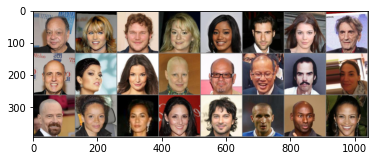

In [ ]:
train_data_iter = iter(trainloader)
test_data_iter = iter(testloader)

classes = ['Unattractive', 'Attractive']
def imshow(img):
    """ show an image """
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = train_data_iter.next()
imshow(torchvision.utils.make_grid(images))

print('  '.join('%5s' % classes[int(labels[j].item())] for j in range(batch_size)))

# Creating the model

## Model variables

In [ ]:
#getting the dimensions
x, y = next(iter(trainloader))
print("Batch dimension [B x C x H x W]:", x.shape)
channels_from_iter = x.shape[1]
height_from_iter = x.shape[2]
width_from_iter = x.shape[3]

#hyperparameters for the model
num_classes = len(selected_attrs)
channels = channels_from_iter
height = height_from_iter
width = width_from_iter

#first convolution
num_filters_conv1 = 96
kernel_size_conv1 = 3
stride_conv1 = 1 
padding_conv1 = 1

#second convolution
num_filters_conv2 = 128
kernel_size_conv2 = 4 
stride_conv2 = 2
padding_conv2 = 2

#hidden layer
num_l1 = 96

Batch dimension [B x C x H x W]: torch.Size([24, 3, 128, 128])


## Defining the model

In [ ]:
def compute_conv_dim(dim_size):
    return int((dim_size - kernel_size_conv2 + 2 * padding_conv2) / stride_conv2 + 1)

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes
        
        #first convolution
        self.conv_1 = Conv2d(in_channels=channels,
                             out_channels=num_filters_conv1,
                             kernel_size=kernel_size_conv1,
                             stride=stride_conv1,
                             padding=padding_conv1)
        
        self.batch_norm1 = BatchNorm2d(num_filters_conv1)
        

        self.conv_2 = Conv2d(in_channels=num_filters_conv1,
                             out_channels=num_filters_conv2,
                             kernel_size=kernel_size_conv2,
                             stride=stride_conv2,
                             padding=padding_conv2)
        
        self.batch_norm2 = BatchNorm2d(num_filters_conv2)
        
        self.conv_out_height = compute_conv_dim(height)
        self.conv_out_width = compute_conv_dim(width)


        self.l1_in_features = num_filters_conv2 * self.conv_out_height * self.conv_out_width
 

        #first layer
        self.l_1 = Linear(in_features=self.l1_in_features,
                          out_features=num_l1,
                          bias=True)
        
        self.dropout = Dropout2d(p=0.3)

        #output layer
        self.l_out = Linear(in_features=num_l1, 
                            out_features=num_classes,
                            bias=False)

    def forward(self, x):
      x = relu(self.conv_1(x))
      x = self.batch_norm1(x)
      x = relu(self.conv_2(x))
      x = self.batch_norm2(x)
      x = x.view(-1, self.l1_in_features)
      x = relu(self.l_1(x))
      x = self.dropout(x)
      return torch.sigmoid(self.l_out(x))
    

net = Net(num_classes)
net.cuda()
print(net)

Net(
  (conv_1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(96, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_1): Linear(in_features=540800, out_features=96, bias=True)
  (dropout): Dropout2d(p=0.3, inplace=False)
  (l_out): Linear(in_features=96, out_features=1, bias=False)
)


# Training the model

## Defining a loss function

In [ ]:
criterion = nn.BCELoss() 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

## Training the model

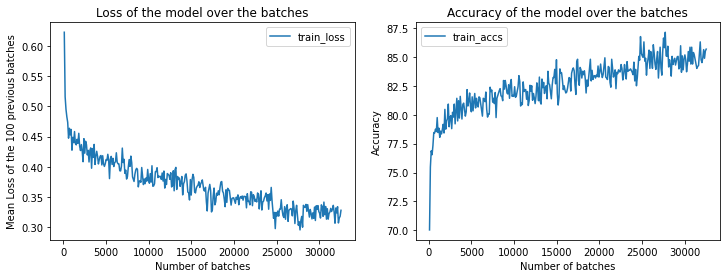

In [ ]:
num_epoch = 4

train_iter = []
train_loss = []
train_accs = []
valid_iter = []
valid_loss = []
valid_accs = []

log_every = 1000
eval_every = 1000

from IPython.display import clear_output

for epoch in range(num_epoch):

    running_loss = 0.0
    net.train()
    correct = 0
    total = 0

    correct_valid = 0
    total_valid = 0
    for i, data in enumerate(trainloader, 0):

##### --- Uncomment this part in order to do the validation as well --- #####
        # if (i % eval_every == 0):
        #   net.eval()
        #   val_losses,val_accs,val_length = 0,0,0
        #   with torch.no_grad():
        #     for j,data in enumerate(validloader,0):
        #       inputs_valid,labels_valid = data
        #       inputs_valid, labels_valid = inputs_valid.cuda(), labels_valid.cuda()

        #       output_valid = net(inputs_valid)
        #       predicted_valid = torch.round(output_valid.data)
        #       correct_valid += (predicted_valid == labels_valid).sum()
        #       total_valid += labels_valid.size(0)

        #       val_losses += criterion(output_valid,labels_valid).item()
        #       val_accs += 100 * correct_valid.true_divide(total_valid)
        #       val_length += 1 

        #     valid_iter.append(i+len(trainloader)*epoch)
        #     valid_loss.append(val_losses/val_length)
        #     valid_accs.append(val_accs/val_length)

        net.train()
        inputs, labels = data

        inputs, labels = inputs.cuda(), labels.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        #forward
        output = net(inputs)
        loss = criterion(output, labels)
        #backward
        loss.backward()

        #optimize
        optimizer.step()


        # print statistics
        running_loss += loss.item()

        predicted = torch.round(output.data)
        correct += (predicted == labels).sum()
        total += labels.size(0)

        if i %100 == 99:
          train_iter.append(i+len(trainloader)*epoch)
          train_loss.append(float(running_loss / 100))
          running_loss = 0.0
          accuracy = 100 * correct.true_divide(total)
          train_accs.append(float(accuracy))
          total = 0
          correct = 0

        if i % log_every == 0:
            fig = plt.figure(figsize=(12,4))
            plt.subplot(1, 2, 1)
            plt.plot(train_iter, train_loss, label='train_loss')

##### --- Uncomment the following line in order to plot the validation evolution --- #####
            # plt.plot(valid_iter, valid_loss, label='valid_loss')
            plt.xlabel("Number of batches")
            plt.ylabel("Mean Loss of the 100 previous batches")
            plt.title("Loss of the model over the batches")
            plt.legend()


            plt.subplot(1, 2, 2)
            plt.plot(train_iter, train_accs, label='train_accs')
          
##### --- Uncomment the following line in order to plot the validation evolution --- #####
            # plt.plot(valid_iter, valid_accs, label='valid_accs')
            plt.legend()
            plt.title("Accuracy of the model over the batches")
            plt.ylabel("Accuracy")
            plt.xlabel("Number of batches")
            plt.show()  
            clear_output(wait=True)

# Saving the trained model

In [ ]:
PATH = drive_path+"ProjetDL/testdata_without.pth"
torch.save(net.state_dict(), PATH)

In [ ]:
PATH = drive_path+"ProjetDL/testdata_with.pth"
torch.save(net.state_dict(), PATH)

# Loading the trained model

The training take more than an hour each time. Therefore, when post-processing the results it is easier to load an already trained model.

## The model trained without added data

In [ ]:
PATH = drive_path+"ProjetDL/testdata_without.pth"
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## The model trained with added data

In [ ]:
PATH = drive_path+"ProjetDL/testdata_with.pth"
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# Viewing the results

## Testing the model

The model that needs to be loaded here is the one trained without the added data.

### Creating the dataframe

In [ ]:
##### TEST DATAFRAME #####
test_df_without_data = pd.DataFrame(testset_allattr)
test_df_without_data.columns = ["image_link","attrs"]
test_df_without_data[[key for key in testset.attr2idx.keys()]] = test_df_without_data['attrs'].apply(pd.Series)
test_df_without_data.pop("attrs")
test_df_without_data["status"]=["Not_known_yet" for i in range(len(test_df_without_data.index))]
test_df_without_data["predicted_value"]=[str(0) for i in range(len(test_df_without_data.index))]

##### TRAIN DATAFRAME #####
train_df_without_data = pd.DataFrame(trainset_allattr)
train_df_without_data.columns = ["image_link","attrs"]
train_df_without_data[[key for key in trainset.attr2idx.keys()]] = train_df_without_data['attrs'].apply(pd.Series)
del train_df_without_data["attrs"]

### Accuracy of the model

In [ ]:
correct = 0
total = 0
idx = 0 
not_predicted_as_attractive_idx_without_data = []

net.eval()
for data in testloader:
    images, labels = data
    labels = labels.cuda()
    outputs = net(images.cuda())
    predicted_raw = outputs.data
    predicted = torch.round(outputs.data)
    predicted = predicted.cuda()
    total += labels.size(0)
    correct += (predicted == labels).sum()
    for predict,predict_raw, real in zip(predicted,predicted_raw,labels):
      test_df_without_data.at[idx,"predicted_value"] = str(predict_raw.item())
      if predict==real:
        if real==1:
          test_df_without_data.at[idx,"status"] = "True Positive"
        else:
          test_df_without_data.at[idx,"status"] = "True Negative"
      else:
        if real==1:
          test_df_without_data.at[idx,"status"] = "False Negative"
        else:
          test_df_without_data.at[idx,"status"] = "False Positive"        

      if predict==0:
        not_predicted_as_attractive_idx_without_data.append(idx)
      idx+=1

print(total)
print(correct)

print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
    len(testset), 100 * correct.true_divide(total)))

19962
tensor(16000, device='cuda:0')
Accuracy of the network on the 19962 test images: 80.15 %


In [ ]:
test_df_without_data['predicted_value']= test_df_without_data['predicted_value'].apply(lambda x : float(x))
attractive_predicted_df = test_df_without_data.drop(not_predicted_as_attractive_idx_without_data)
attractive_predicted_df.head()

,image_link,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,status,predicted_value
0,199242.jpg,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False Positive,0.514208
1,189733.jpg,False,False,True,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,True,False,True,False,True,False,True,False,False,True,True,False,True,True Positive,0.727866
6,185254.jpg,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,True,False,True,False,True,False,False,True,False,True,False,False,True,True Positive,0.744254
8,187591.jpg,False,True,True,True,False,False,True,True,True,False,False,False,True,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,True Positive,0.616067
12,183249.jpg,False,True,True,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,True,True,False,True,False,False,True,True,False,True,False,True,False,True,False,False,True,False,True,False,False,True,True Positive,0.836090


## Best and worst classified pictures

**1. Least attractive**

In [ ]:
test_df_without_data.sort_values(by='predicted_value').head()

,image_link,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,status,predicted_value
8616,186706.jpg,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True Negative,7.850181e-09
4856,195079.jpg,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,True,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True Negative,1.184525e-08
1689,184915.jpg,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,True,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True Negative,1.374571e-08
4264,197504.jpg,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,True,False,True,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True Negative,1.812096e-08
5602,185465.jpg,False,False,False,False,False,False,True,True,True,False,False,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,True Negative,1.946956e-08


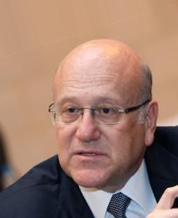

In [ ]:
#Least attractive pictures
path0 = r'lesimages/img_align_celeba/'+'186706.jpg'
img0 = cv2.imread(path0) 
cv2_imshow(img0)

**2. Most attractive**

In [ ]:
test_df_without_data.sort_values(by='predicted_value', ascending=False).head()

,image_link,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,status,predicted_value
17858,190946.jpg,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,True,False,False,False,True,False,True,False,True,False,False,True,False,False,True,True Positive,1.000000
15910,192599.jpg,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,True,True,True,False,False,False,True,False,True,False,False,True,False,True,False,False,True,True Positive,1.000000
2612,187635.jpg,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,True,False,False,True,True,True,False,False,False,False,True,False,True,False,False,True,False,False,True,True Positive,0.999999
18267,195818.jpg,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,False,True,True,False,True,False,False,False,True,False,False,False,False,True,False,False,True,True Positive,0.999999
2934,198191.jpg,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,False,True,True,False,True,False,False,False,True,True,False,False,False,True,False,False,True,True Positive,0.999999


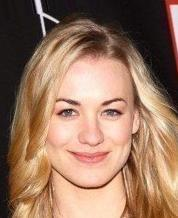

In [ ]:
#Most attractive picture
path0 = r'lesimages/img_align_celeba/'+'190946.jpg'
img0 = cv2.imread(path0) 
cv2_imshow(img0)

## Attributes amongst populations

**1. Proportions of False Positives in the classified images**

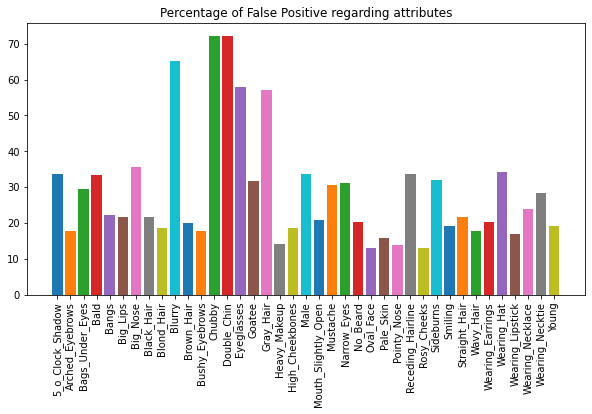

In [ ]:
### Proportion of False Positive regarding attributes: 

fig = plt.figure(figsize=(10,5)) 

interesting_features = ["Bald","Young","Heavy_Makeup","Male","Pale_Skin","Smiling"]

# Plot accidents depending on type
i=1

for attr in trainset.attr2idx.keys():
  if attr!="Attractive" and len(test_df_without_data[(test_df_without_data["status"].isin(["True Positive","False Positive"])) & (test_df_without_data[attr]==True)]):
    plt.bar(i,len(test_df_without_data[(test_df_without_data["status"]=="False Positive") & (test_df_without_data[attr]==True)])/len(test_df_without_data[(test_df_without_data["status"].isin(["True Positive","False Positive"])) & (test_df_without_data[attr]==True)])*100)
    i+=1

plt.xticks([r for r in range(1,len(trainset.attr2idx.keys()))], [attr for attr in trainset.attr2idx.keys() if attr!="Attractive" and len(test_df_without_data[(test_df_without_data["status"].isin(["True Positive","False Positive"])) & (test_df_without_data[attr]==True)])],rotation=90)

plt.title("Percentage of False Positive regarding attributes")
plt.show()

**2. Proportions of attributes in the train and predicted attractive populations**

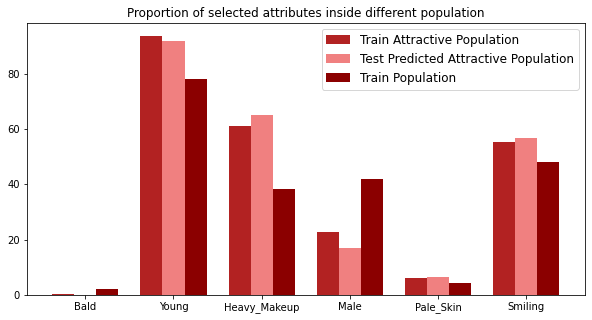

In [ ]:
train_df = pd.DataFrame(trainset_allattr)
train_df.columns = ["image_link","attrs"]
train_df[[key for key in trainset.attr2idx.keys()]] = train_df['attrs'].apply(pd.Series)
train_df.pop("attrs")

fig = plt.figure(figsize=(10,5)) 

interesting_features = ["Bald","Young","Heavy_Makeup","Male","Pale_Skin","Smiling"]
i=1
barWidth = 0.25

for attr in interesting_features:
  if attr!="Attractive":
    plt.bar(i,len(train_df[(train_df["Attractive"]==True) & (train_df[attr]==True)])/len(train_df[train_df["Attractive"]==True])*100,color='#B22222',width=barWidth,label="Train Attractive Population" if i==1 else "")
    plt.bar(i+barWidth,len(attractive_predicted_df[attractive_predicted_df[attr]==True])/len(attractive_predicted_df)*100,color='#F08080',width=barWidth,label="Test Predicted Attractive Population" if i==1 else "")
    plt.bar(i+barWidth*2,len(train_df[train_df[attr]==True])/len(train_df)*100,color='#8B0000',width=barWidth,label="Train Population" if i==1 else "")
    i+=1

plt.xticks([r + barWidth for r in range(1,len(interesting_features)+1)], [attr for attr in interesting_features])

plt.title("Proportion of selected attributes inside different population")
plt.legend(prop={'size': 12})
plt.show()

**3. Best and Worst attributes to have to be classified attractive**

In [ ]:
test_df = test_df_without_data

test_best_attr = {attr:len(test_df[(test_df["Attractive"]==True) & (test_df[attr]==True)])/len(test_df[test_df["Attractive"]==True])*100 if attr!="Attractive" else 0 for attr in testset.attr2idx.keys()}
predict_best_attr = {attr:len(test_df[(test_df["status"].isin(['False Positive',"True Positive"])) & (test_df[attr]==True)])/len(test_df[test_df["status"].isin(['False Positive',"True Positive"])])*100 if attr!="Attractive" else 0 for attr in testset.attr2idx.keys()}
top_5_best_attr_test = sorted(test_best_attr.items(),key=lambda x: x[1],reverse=True)[:5]
top_5_best_attr_predict = sorted(predict_best_attr.items(),key=lambda x: x[1],reverse=True)[:5]
top_5_worst_attr_test = sorted(test_best_attr.items(),key=lambda x: x[1])[1:6]
top_5_worst_attr_predict = sorted(predict_best_attr.items(),key=lambda x: x[1])[1:6]

print("---------- Statistics in Test Dataset vs Network output ----------")
print("\n")
print("Top Attributes to have")
print("--------------")
print("\n".join(map(lambda x,y: x[0]+' '+y[0]+" = "+str(round(x[1],2))+"% vs "+str(round(y[1],2))+"%",top_5_best_attr_test,top_5_best_attr_predict)))
print("\n")
print("Worst Attributes to have")
print("--------------")
print("\n".join(map(lambda x,y: x[0]+' '+y[0]+" = "+str(round(x[1],2))+"% vs "+str(round(y[1],2))+"%",top_5_worst_attr_test,top_5_worst_attr_predict)))

---------- Statistics in Test Dataset vs Network output ----------


Top Attributes to have
--------------
Young No_Beard = 92.1% vs 93.14%
No_Beard Young = 92.06% vs 91.77%
Wearing_Lipstick Wearing_Lipstick = 76.1% vs 78.06%
Heavy_Makeup Heavy_Makeup = 63.6% vs 64.88%
Smiling Smiling = 56.49% vs 56.75%


Worst Attributes to have
--------------
Bald Bald = 0.15% vs 0.03%
Gray_Hair Gray_Hair = 0.18% vs 0.14%
Double_Chin Double_Chin = 0.26% vs 0.42%
Chubby Chubby = 0.31% vs 0.53%
Eyeglasses Eyeglasses = 1.04% vs 0.6%


# Fairness evaluation : fairness metrics calculation

### Attribute "Eyeglasses"

In [ ]:
print("----------STATISCTICS WITHOUT DATA - EYEGLASSES ATTRIBUTE ----------")
print("\n")
print("Statistical Parity")
#P(M(X)=1 | A=a) = P(M(X)=1 | B=b)
print(len(test_df[(test_df["status"].isin(["False Positive","True Positive"])) & (test_df["Eyeglasses"]==True)])/len(test_df[test_df["Eyeglasses"]==True]))
print(len(test_df[(test_df["status"].isin(["False Positive","True Positive"])) & (test_df["Eyeglasses"]==False)])/len(test_df[test_df["Eyeglasses"]==False]))
print("\n")
print("True Positive Rate")
#P(M(X)=1 | A=a, y=1) = P(M(X)=1 | A=b, y=1)
print("--------------")
print(len(test_df[(test_df["status"]=="True Positive") & (test_df["Eyeglasses"]==True)])/len(test_df[(test_df["status"].isin(["False Negative","True Positive"])) & (test_df["Eyeglasses"]==True)]))
print(len(test_df[(test_df["status"]=="True Positive") & (test_df["Eyeglasses"]==False)])/len(test_df[(test_df["status"].isin(["False Negative","True Positive"])) & (test_df["Eyeglasses"]==False)]))
print("\n")
print("False Positive Rate")
#P(M(X)=1 | A=a, y=0) = P(M(X)=1 | A=b, y=0)
print("----------------")
print(len(test_df[(test_df["status"]=="False Positive") & (test_df["Eyeglasses"]==True)])/len(test_df[(test_df["status"].isin(["True Negative","False Positive"])) & (test_df["Eyeglasses"]==True)]))
print(len(test_df[(test_df["status"]=="False Positive") & (test_df["Eyeglasses"]==False)])/len(test_df[(test_df["status"].isin(["True Negative","False Positive"])) & (test_df["Eyeglasses"]==False)]))


----------STATISCTICS WITHOUT DATA - EYEGLASSES ATTRIBUTE ----------


Statistical Parity
0.04809930178432894
0.5462432389010872


True Positive Rate
--------------
0.2524271844660194
0.8241960183767228


False Positive Rate
----------------
0.03035413153456998
0.2395809867087182


### Attribute "Bald"

In [ ]:
test_df = test_df_without_data

print("----------STATISCTICS WITHOUT DATA - BALD ATTRIBUTE ----------")
print("\n")
print("Statistical Parity")
#P(M(X)=1 | A=a) = P(M(X)=1 | B=b)
print(len(test_df[(test_df["status"].isin(["False Positive","True Positive"])) & (test_df["Bald"]==True)])/len(test_df[test_df["Bald"]==True]))
print(len(test_df[(test_df["status"].isin(["False Positive","True Positive"])) & (test_df["Bald"]==False)])/len(test_df[test_df["Bald"]==False]))
print("\n")
print("True Positive Rate")
#P(M(X)=1 | A=a, y=1) = P(M(X)=1 | A=b, y=1)
print("--------------")
print(len(test_df[(test_df["status"]=="True Positive") & (test_df["Bald"]==True)])/len(test_df[(test_df["status"].isin(["False Negative","True Positive"])) & (test_df["Bald"]==True)]))
print(len(test_df[(test_df["status"]=="True Positive") & (test_df["Bald"]==False)])/len(test_df[(test_df["status"].isin(["False Negative","True Positive"])) & (test_df["Bald"]==False)]))
print("\n")
print("False Positive Rate")
#P(M(X)=1 | A=a, y=0) = P(M(X)=1 | A=b, y=0)
print("----------------")
print(len(test_df[(test_df["status"]=="False Positive") & (test_df["Bald"]==True)])/len(test_df[(test_df["status"].isin(["True Negative","False Positive"])) & (test_df["Bald"]==True)]))
print(len(test_df[(test_df["status"]=="False Positive") & (test_df["Bald"]==False)])/len(test_df[(test_df["status"].isin(["True Negative","False Positive"])) & (test_df["Bald"]==False)]))


----------STATISCTICS WITHOUT DATA - BALD ATTRIBUTE ----------


Statistical Parity
0.0070921985815602835
0.5250524591841957


True Positive Rate
--------------
0.13333333333333333
0.819285642011535


False Positive Rate
----------------
0.0024509803921568627
0.22390223695111847


# First fix : Adjusting the thresholds

## Calculating the FPR and TPR for different thresholds

In [ ]:
 def get_rates(treshold, attr):
  #create the dataframe
  test_df = pd.DataFrame(testset_allattr)
  test_df.columns = ["image_link","attrs"]
  test_df[[key for key in testset.attr2idx.keys()]] = test_df['attrs'].apply(pd.Series)
  test_df.pop("attrs")
  test_df["status"]=["Not_known_yet" for i in range(len(test_df.index))]
  test_df.head()

  #do the test
  correct = 0
  total = 0
  idx = 0 
  not_predicted_as_attractive_idx = []

  net.eval()
  for data in testloader:
      images, labels = data
      labels = labels.cuda()
      outputs = net(images.cuda())
      predicted = torch.round(outputs.data - treshold + 0.5)
      predicted = predicted.cuda()
      total += labels.size(0)
      correct += (predicted == labels).sum()

      for predict,real in zip(predicted,labels):

        if predict==real:
          if real==1:
            test_df.at[idx,"status"] = "True Positive"
          else:
            test_df.at[idx,"status"] = "True Negative"
        else:
          if real==1:
            test_df.at[idx,"status"] = "False Negative"
          else:
            test_df.at[idx,"status"] = "False Positive"        

        if predict==0:
          not_predicted_as_attractive_idx.append(idx)
        idx+=1

  print("treshold : " + str(treshold)+'\n')
  print(total)
  print(correct)
  #ici nous on a pas testset.data
  print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
      len(testset), 100 * correct.true_divide(total)))

  #false positive rate with attribute
  fp_w = len(test_df[(test_df["status"]=="False Positive") & (test_df[attr]==True)])/len(test_df[(test_df["status"].isin(["True Negative","False Positive"])) & (test_df[attr]==True)])
  #true positive rate with attribute
  tp_w = len(test_df[(test_df["status"]=="True Positive") & (test_df[attr]==True)])/len(test_df[(test_df["status"].isin(["False Negative","True Positive"])) & (test_df[attr]==True)])
  #false positive rate without attribute
  fp_wo = len(test_df[(test_df["status"]=="False Positive") & (test_df[attr]==False)])/len(test_df[(test_df["status"].isin(["True Negative","False Positive"])) & (test_df[attr]==False)])
  #true positive rate without attribute
  tp_wo = len(test_df[(test_df["status"]=="True Positive") & (test_df[attr]==False)])/len(test_df[(test_df["status"].isin(["False Negative","True Positive"])) & (test_df[attr]==False)])

  return tp_w, fp_w, tp_wo, fp_wo

## Plotting the ROC curves

treshold : 0.0

19962
tensor(9905, device='cuda:0')
Accuracy of the network on the 19962 test images: 49.62 %
treshold : 0.05

19962
tensor(13298, device='cuda:0')
Accuracy of the network on the 19962 test images: 66.62 %
treshold : 0.1

19962
tensor(13924, device='cuda:0')
Accuracy of the network on the 19962 test images: 69.75 %
treshold : 0.15000000000000002

19962
tensor(14386, device='cuda:0')
Accuracy of the network on the 19962 test images: 72.07 %
treshold : 0.2

19962
tensor(14740, device='cuda:0')
Accuracy of the network on the 19962 test images: 73.84 %
treshold : 0.25

19962
tensor(15104, device='cuda:0')
Accuracy of the network on the 19962 test images: 75.66 %
treshold : 0.30000000000000004

19962
tensor(15350, device='cuda:0')
Accuracy of the network on the 19962 test images: 76.90 %
treshold : 0.35000000000000003

19962
tensor(15621, device='cuda:0')
Accuracy of the network on the 19962 test images: 78.25 %
treshold : 0.4

19962
tensor(15811, device='cuda:0')
Accuracy o

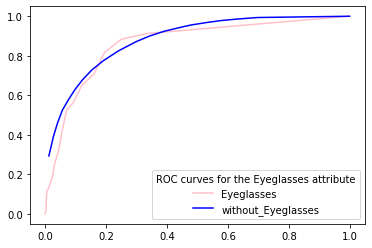

In [ ]:
category = 'Eyeglasses'
i = 0
x_w = []
y_w = []
x_wo = []
y_wo = []
interval = np.arange(0,1,0.05)
for t in interval:
  result = get_rates(t, category)
  y_w.append(result[0])
  x_w.append(result[1])
  y_wo.append(result[2])
  x_wo.append(result[3])

plt.plot(x_w,y_w, label = category, color = 'pink' )
plt.plot(x_wo,y_wo, label = 'without_'+category, color = 'blue')
plt.legend(title='ROC curves for the Eyeglasses attribute')
plt.show()

## Finding the tresholds

In [ ]:
#Printing the rates
print('TPR for eyeglasses')
print(x_w)
print('FPR for eyeglasses')
print(y_w)
print('TPR without eyeglasses')
print(x_wo)
print('FPR without eyeglasses')
print(y_wo)

TPR for eyeglasses
[0.9966273187183811, 0.33389544688026984, 0.24957841483979765, 0.19392917369308602, 0.16020236087689713, 0.11973018549747048, 0.09190556492411467, 0.0699831365935919, 0.05480607082630692, 0.04384485666104553, 0.03035413153456998, 0.024451939291736932, 0.016863406408094434, 0.01433389544688027, 0.012647554806070826, 0.00927487352445194, 0.00505902192242833, 0.003372681281618887, 0.002529510961214165, 0.0]
FPR for eyeglasses
[1.0, 0.912621359223301, 0.883495145631068, 0.8155339805825242, 0.7087378640776699, 0.6504854368932039, 0.5631067961165048, 0.5242718446601942, 0.4174757281553398, 0.32038834951456313, 0.2524271844660194, 0.1941747572815534, 0.1553398058252427, 0.14563106796116504, 0.13592233009708737, 0.1262135922330097, 0.11650485436893204, 0.06796116504854369, 0.019417475728155338, 0.0]
TPR without eyeglasses
[0.9996620860554178, 0.6979049335435908, 0.6296463167380041, 0.575580085604866, 0.5278215814372607, 0.47814823158369, 0.4375985582338365, 0.389840054066231

We choose tresholds so that the rates are equal

In [ ]:
#Choosing a treshold of 0.4 for people with eyeglasses
print(get_rates(0.4, "Eyeglasses"))
#with eye glasses :
#true positive rate : 0.4563106796116505
#false positive rate : 0.046374367622259695

treshold : 0.4

19962
tensor(15945, device='cuda:0')
Accuracy of the network on the 19962 test images: 79.88 %
(0.4563106796116505, 0.046374367622259695, 0.8967840735068913, 0.32608695652173914)


In [ ]:
#Choosing a treshold of 0.85 for people without eyeglasses
print(get_rates(0.85, "Eyeglasses"))
#without eye glasses :
#true positive rate : 0.46248085758039814
#false positive rate : 0.04190132912818202

treshold : 0.85

19962
tensor(14225, device='cuda:0')
Accuracy of the network on the 19962 test images: 71.26 %
(0.02912621359223301, 0.0, 0.46248085758039814, 0.04190132912818202)


# Second fix : Adding data

## With added data

Here the model that needs to be loaded is the one trained with the added data.

In [ ]:
##### TEST DATAFRAME #####
test_df_with_data = pd.DataFrame(testset_allattr)
test_df_with_data.columns = ["image_link","attrs"]
test_df_with_data[[key for key in testset.attr2idx.keys()]] = test_df_with_data['attrs'].apply(pd.Series)
test_df_with_data.pop("attrs")
test_df_with_data["status"]=["Not_known_yet" for i in range(len(test_df_with_data.index))]
test_df_with_data["predicted_value"]=[str(0) for i in range(len(test_df_with_data.index))]

##### TRAIN DATAFRAME #####
train_df_with_data = pd.DataFrame(trainset_allattr)
train_df_with_data.columns = ["image_link","attrs"]
train_df_with_data[[key for key in trainset.attr2idx.keys()]] = train_df_with_data['attrs'].apply(pd.Series)
del train_df_with_data["attrs"]

### Testing the model

In [ ]:
correct = 0
total = 0
idx = 0 
not_predicted_as_attractive_idx_with_data = []

net.eval()
for data in testloader:
    images, labels = data
    labels = labels.cuda()
    outputs = net(images.cuda())
    predicted_raw = outputs.data
    predicted = torch.round(outputs.data)
    predicted = predicted.cuda()
    total += labels.size(0)
    correct += (predicted == labels).sum()
    for predict,predict_raw, real in zip(predicted,predicted_raw,labels):
      test_df_with_data.at[idx,"predicted_value"] = str(predict_raw.item())
      if predict==real:
        if real==1:
          test_df_with_data.at[idx,"status"] = "True Positive"
        else:
          test_df_with_data.at[idx,"status"] = "True Negative"
      else:
        if real==1:
          test_df_with_data.at[idx,"status"] = "False Negative"
        else:
          test_df_with_data.at[idx,"status"] = "False Positive"        

      if predict==0:
        not_predicted_as_attractive_idx_with_data.append(idx)
      idx+=1

print(total)
print(correct)

print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
    len(testset), 100 * correct.true_divide(total)))

19962
tensor(16038, device='cuda:0')
Accuracy of the network on the 19962 test images: 80.34 %


**1. Proportions of False Positives in the classified images**

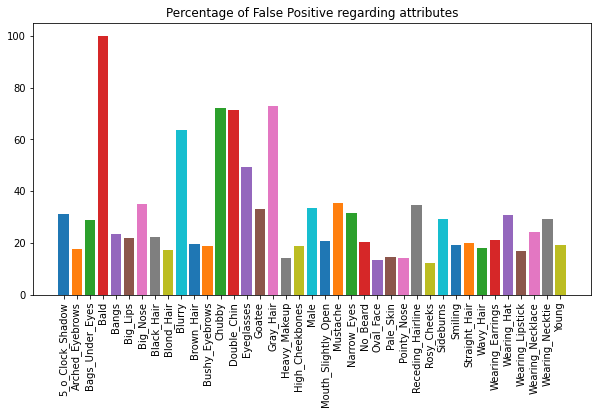

In [ ]:
### Proportion of False Positive regarding attributes: 

fig = plt.figure(figsize=(10,5)) 

interesting_features = ["Bald","Young","Heavy_Makeup","Male","Pale_Skin","Smiling"]

# Plot accidents depending on type
#for attr in trainset.attr2idx.keys():
i=1

for attr in trainset.attr2idx.keys():
  if attr!="Attractive":
    #print(attr+" TP+FP:"+str(len(test_df_with_data[(test_df_with_data["status"].isin(["False Positive"])) & (test_df_with_data[attr]==True)])))
    plt.bar(i,len(test_df_with_data[(test_df_with_data["status"]=="False Positive") & (test_df_with_data[attr]==True)])/len(test_df_with_data[(test_df_with_data["status"].isin(["True Positive","False Positive"])) & (test_df_with_data[attr]==True)])*100)
    i+=1

plt.xticks([r for r in range(1,len(trainset.attr2idx.keys()))], [attr for attr in trainset.attr2idx.keys() if attr!="Attractive"],rotation=90)

plt.title("Percentage of False Positive regarding attributes")
plt.show()

**2. Proportions of attributes in the train and predicted attractive populatioins**

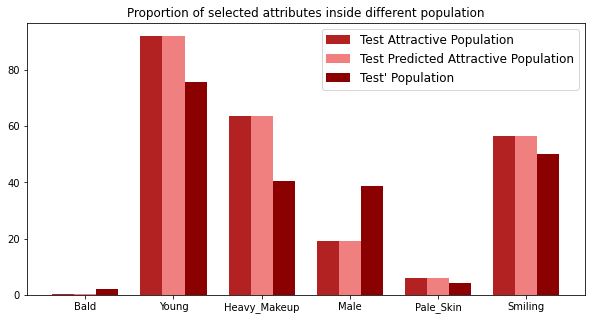

In [ ]:
# Set up a grid of plots
fig = plt.figure(figsize=(10,5)) 

interesting_features = ["Bald","Young","Heavy_Makeup","Male","Pale_Skin","Smiling"]

# Plot accidents depending on type
#for attr in trainset.attr2idx.keys():
i=1
barWidth = 0.25

for attr in interesting_features:
  if attr!="Attractive":
   #plt.bar([attr+"A",attr],[len(train_df_with_data[(train_df_with_data["Attractive"]==True) & (train_df_with_data[attr]==True)])/len(train_df_with_data[train_df_with_data["Attractive"]==True])*100,len(train_df_with_data[train_df_with_data[attr]==True])/len(train_df_with_data)*100])
    plt.bar(i,len(test_df_with_data[(test_df_with_data["Attractive"]==True) & (test_df_with_data[attr]==True)])/len(test_df_with_data[test_df_with_data["Attractive"]==True])*100,color='#B22222',width=barWidth,label="Test Attractive Population" if i==1 else "")
    plt.bar(i+barWidth,len(test_df_with_data[(test_df_with_data[attr]==True) & (test_df_with_data["status"].isin(["True Positive","False Negative"]))])/len(test_df_with_data[test_df_with_data["status"].isin(["True Positive","False Negative"])])*100,color='#F08080',width=barWidth,label="Test Predicted Attractive Population" if i==1 else "")
    plt.bar(i+barWidth*2,len(test_df_with_data[test_df_with_data[attr]==True])/len(test_df_with_data)*100,color='#8B0000',width=barWidth,label="Test' Population" if i==1 else "")
    i+=1

plt.xticks([r + barWidth for r in range(1,len(interesting_features)+1)], [attr for attr in interesting_features])

plt.title("Proportion of selected attributes inside different population")
plt.legend(prop={'size': 12})
plt.show()

## Comparison between with and without added data

### Proportion of attributes


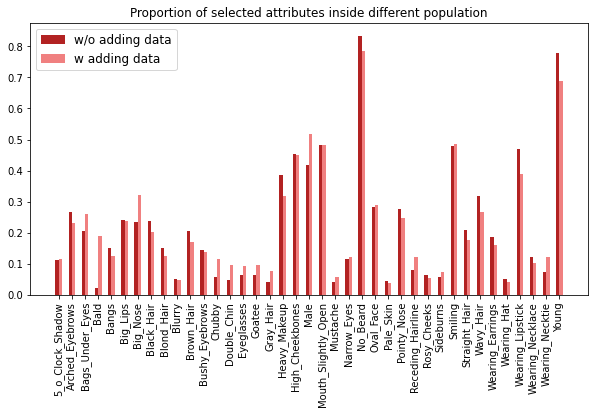

In [ ]:
# Set up a grid of plots
fig = plt.figure(figsize=(10,5)) 

# Plot accidents depending on type
x_attr = list(trainset.attr2idx.keys())
x_attr.remove("Attractive")

i=1
barWidth = 0.25

for attr in x_attr:
    y_percentage_without_data = len(train_df_without_data[train_df_without_data[attr]==True])/len(train_df_without_data)
    y_percentage_with_data = len(train_df_with_data[train_df_with_data[attr]==True])/len(train_df_with_data)

    plt.bar(i,y_percentage_without_data,color='#B22222',width=barWidth,label="w/o adding data" if i==1 else "")
    plt.bar(i+barWidth,y_percentage_with_data,color='#F08080',width=barWidth,label="w adding data" if i==1 else "")
    i+=1

barWidth = 0.25

plt.xticks([r + barWidth/2 for r in range(1,len(x_attr)+1)], [attr for attr in x_attr],rotation=90)
plt.legend(prop={'size': 12})
plt.title("Proportion of selected attributes inside different population")
plt.show()

In [ ]:
# Train with data
test_best_attr_with_data = {attr:len(test_df_with_data[(test_df_with_data["Attractive"]==True) & (test_df_with_data[attr]==True)])/len(test_df_with_data[test_df_with_data["Attractive"]==True])*100 if attr!="Attractive" else 0 for attr in trainset.attr2idx.keys()}
top_5_best_attr_test_w_d = sorted(test_best_attr_with_data.items(),key=lambda x: x[1],reverse=True)[:5]
top_5_worst_attr_test_w_d = sorted(test_best_attr_with_data.items(),key=lambda x: x[1])[1:6]

# predict with data
predict_best_attr_w_d = {attr:len(test_df_with_data[(test_df_with_data["status"].isin(["False Positive","True Positive"])) & (test_df_with_data[attr]==True)])/len(test_df_with_data[test_df_with_data["status"].isin(["False Positive","True Positive"])])*100 if attr!="Attractive" else 0 for attr in trainset.attr2idx.keys()}
top_5_best_attr_predict_w_d = [predict_best_attr_w_d[tu[0]] for tu in top_5_best_attr_test_w_d]
top_5_worst_attr_predict_w_d = [predict_best_attr_w_d[tu[0]] for tu in top_5_worst_attr_test_w_d]

#Train without data added
test_best_attr_without_data = {attr:len(test_df_without_data[(test_df_without_data["Attractive"]==True) & (test_df_without_data[attr]==True)])/len(test_df_without_data[test_df_without_data["Attractive"]==True])*100 if attr!="Attractive" else 0 for attr in trainset.attr2idx.keys()}
top_5_best_attr_test_without_d = sorted(test_best_attr_without_data.items(),key=lambda x: x[1],reverse=True)[:5]
top_5_worst_attr_test_without_d = sorted(test_best_attr_without_data.items(),key=lambda x: x[1])[1:6]

#Predict without data added
predict_best_attr_without_d = {attr:len(test_df_without_data[(test_df_without_data["status"].isin(["False Positive","True Positive"])) & (test_df_without_data[attr]==True)])/len(test_df_without_data[test_df_without_data["status"].isin(["False Positive","True Positive"])])*100 if attr!="Attractive" else 0 for attr in trainset.attr2idx.keys()}
top_5_best_attr_predict_without_d = [predict_best_attr_without_d[tu[0]] for tu in top_5_best_attr_test_without_d]
top_5_worst_attr_predict_without_d = [predict_best_attr_without_d[tu[0]] for tu in top_5_worst_attr_test_without_d]

print("---------- Statistics in Test Dataset vs Network output WITH DATA ----------")
print("\n")
print("Top Attributes to have")
print("--------------")
print("\n".join(map(lambda x,y: x[0]+" = "+str(round(x[1],2))+"% vs "+str(round(y,2))+"%",top_5_best_attr_test_w_d,top_5_best_attr_predict_w_d)))
print("\n")
print("Worst Attributes to have")
print("--------------")
print("\n".join(map(lambda x,y: x[0]+" = "+str(round(x[1],2))+"% vs "+str(round(y,2))+"%",top_5_worst_attr_test_w_d,top_5_worst_attr_predict_w_d)))
print("\n")
print("---------- Statistics in Test Dataset vs Network output WITHOUT DATA ADDED----------")
print("\n")
print("Top Attributes to have")
print("--------------")
print("\n".join(map(lambda x,y: x[0]+" = "+str(round(x[1],2))+"% vs "+str(round(y,2))+"%",top_5_best_attr_test_without_d,top_5_best_attr_predict_without_d)))
print("\n")
print("Worst Attributes to have")
print("--------------")
print("\n".join(map(lambda x,y: x[0]+" = "+str(round(x[1],2))+"% vs "+str(round(y,2))+"%",top_5_worst_attr_test_without_d,top_5_worst_attr_predict_without_d)))

---------- Statistics in Test Dataset vs Network output WITH DATA ----------


Top Attributes to have
--------------
Young = 92.1% vs 91.73%
No_Beard = 92.06% vs 93.75%
Wearing_Lipstick = 76.1% vs 78.88%
Heavy_Makeup = 63.6% vs 65.65%
Smiling = 56.49% vs 57.19%


Worst Attributes to have
--------------
Bald = 0.15% vs 0.03%
Gray_Hair = 0.18% vs 0.11%
Double_Chin = 0.26% vs 0.51%
Chubby = 0.31% vs 0.56%
Eyeglasses = 1.04% vs 0.58%


---------- Statistics in Test Dataset vs Network output WITHOUT DATA ADDED----------


Top Attributes to have
--------------
Young = 92.1% vs 91.77%
No_Beard = 92.06% vs 93.14%
Wearing_Lipstick = 76.1% vs 78.06%
Heavy_Makeup = 63.6% vs 64.88%
Smiling = 56.49% vs 56.75%


Worst Attributes to have
--------------
Bald = 0.15% vs 0.03%
Gray_Hair = 0.18% vs 0.14%
Double_Chin = 0.26% vs 0.42%
Chubby = 0.31% vs 0.53%
Eyeglasses = 1.04% vs 0.6%
